## CTKD with CIFAR100

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import torchvision.models as models
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss

In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
num_epochs = 240  # 200
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
# weight_decay_input = 5e-4
weight_decay=1e-4
initial_temperature = 20.0

# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [4]:
# # Load IdenProf dataset
# train_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/train'
# test_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

trainloader, testloader  = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model = models.resnet34(pretrained=True).to(device)
teacher_model.fc = nn.Linear(512, num_classes)

student_model = models.resnet18(pretrained=False).to(device)
student_model.fc = nn.Linear(512, num_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Loss and Optimizer
teacher_criterion = nn.CrossEntropyLoss()
student_criterion = nn.KLDivLoss(reduction='batchmean')
criterion = nn.CrossEntropyLoss()

teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001, weight_decay=weight_decay)  # L2 regularization to prevent overfitting

teacher_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(teacher_optimizer, 'min', patience=3, factor=0.5)
student_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=3, factor=0.5)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
# # CKD Optimizer and scheduler for the student model
# student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
# student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# # Optimizer and scheduler for the teacher model
# teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
# teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# criterion = nn.CrossEntropyLoss()

# # Assuming the device is a CUDA device if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|████████████████████████████████████████████████████████████████████████| 782/782 [05:35<00:00,  2.33it/s]


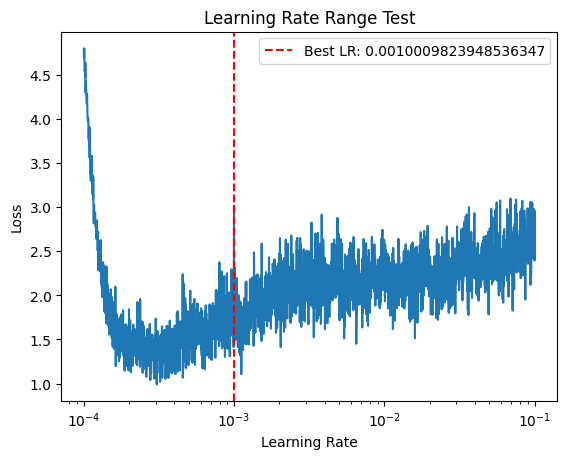

Best learning rate: 0.0010009823948536347
0.0010009823948536347


In [9]:
batch_size = 16  #to find the optimal learning rate
teacher_best_lr = train_teacher(teacher_model, trainloader, 
                                teacher_criterion, teacher_optimizer, teacher_scheduler, 
                                device, num_epochs=3)  
print(teacher_best_lr)

100%|████████████████████████████████████████████████████████████████████████| 782/782 [03:58<00:00,  3.28it/s]


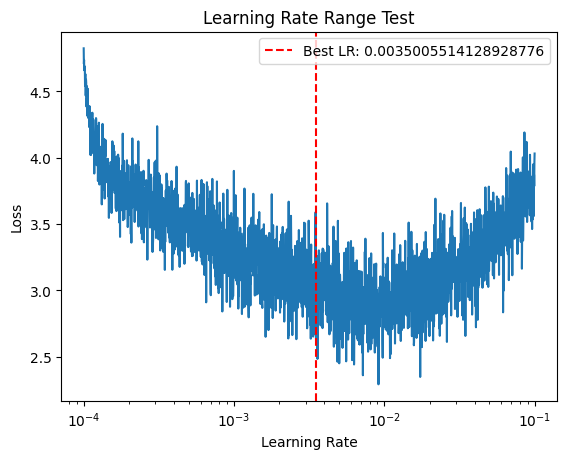

Best learning rate: 0.0035005514128928776
0.0035005514128928776


In [9]:
student_best_lr = train_teacher(student_model, trainloader, 
                                criterion, student_optimizer, student_scheduler, 
                                device, num_epochs=3)  
print(student_best_lr)

In [10]:
# teacher_learning_rate = teacher_best_lr
# student_learning_rate = student_best_lr

teacher_learning_rate = 0.0010009823948536347
student_learning_rate = 0.0035005514128928776

# student_learning_rate = 0.001

In [26]:
# Loss and Optimizer
teacher_criterion = nn.CrossEntropyLoss()
student_criterion = nn.KLDivLoss(reduction='batchmean')
criterion = nn.CrossEntropyLoss()

teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=teacher_learning_rate)
student_optimizer = optim.Adam(student_model.parameters(), lr=student_learning_rate, 
                               weight_decay=weight_decay)  # L2 regularization to prevent overfitting

teacher_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(teacher_optimizer, 'min', patience=3, factor=0.5)
student_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=3, factor=0.5)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ctkd_cifar100_checkpoint.pth')
            torch.save(model, f'teacher_model_ctkd_cifar100_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step(epoch_loss)

    print("Finished Training Teacher")

In [10]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, teacher_criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)


 13%|█████████▏                                                              | 100/782 [00:43<04:50,  2.34it/s]

[1, 100] loss: 3.757


 26%|██████████████████▍                                                     | 200/782 [01:26<04:09,  2.34it/s]

[1, 200] loss: 2.879


 38%|███████████████████████████▌                                            | 300/782 [02:09<03:25,  2.34it/s]

[1, 300] loss: 2.485


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[1, 400] loss: 2.294


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[1, 500] loss: 2.106


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.31it/s]

[1, 600] loss: 1.987


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[1, 700] loss: 1.875


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[2, 100] loss: 1.560


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[2, 200] loss: 1.565


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[2, 300] loss: 1.539


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[2, 400] loss: 1.492


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[2, 500] loss: 1.418


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[2, 600] loss: 1.436


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[2, 700] loss: 1.393


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[3, 100] loss: 1.109


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[3, 200] loss: 1.071


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[3, 300] loss: 1.101


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[3, 400] loss: 1.113


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.35it/s]

[3, 500] loss: 1.128


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[3, 600] loss: 1.087


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[3, 700] loss: 1.110


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[4, 100] loss: 0.802


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[4, 200] loss: 0.790


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.34it/s]

[4, 300] loss: 0.845


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[4, 400] loss: 0.838


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[4, 500] loss: 0.844


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[4, 600] loss: 0.839


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[4, 700] loss: 0.866


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[5, 100] loss: 0.588


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[5, 200] loss: 0.556


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[5, 300] loss: 0.594


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[5, 400] loss: 0.606


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[5, 500] loss: 0.641


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[5, 600] loss: 0.658


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[5, 700] loss: 0.650


 13%|█████████▏                                                              | 100/782 [00:43<04:52,  2.33it/s]

[6, 100] loss: 0.400


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[6, 200] loss: 0.367


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.33it/s]

[6, 300] loss: 0.395


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[6, 400] loss: 0.427


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[6, 500] loss: 0.446


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[6, 600] loss: 0.455


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.32it/s]

[6, 700] loss: 0.507


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[7, 100] loss: 0.273


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.32it/s]

[7, 200] loss: 0.224


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[7, 300] loss: 0.271


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:45,  2.31it/s]

[7, 400] loss: 0.308


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[7, 500] loss: 0.334


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[7, 600] loss: 0.373


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[7, 700] loss: 0.365


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.33it/s]

[8, 100] loss: 0.190


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[8, 200] loss: 0.178


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:28,  2.31it/s]

[8, 300] loss: 0.196


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[8, 400] loss: 0.233


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[8, 500] loss: 0.258


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[8, 600] loss: 0.264


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[8, 700] loss: 0.324


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.34it/s]

[9, 100] loss: 0.185


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[9, 200] loss: 0.148


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.33it/s]

[9, 300] loss: 0.145


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[9, 400] loss: 0.165


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[9, 500] loss: 0.191


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[9, 600] loss: 0.230


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[9, 700] loss: 0.242


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[10, 100] loss: 0.153


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[10, 200] loss: 0.120


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[10, 300] loss: 0.125


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[10, 400] loss: 0.147


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[10, 500] loss: 0.171


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[10, 600] loss: 0.214


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.32it/s]

[10, 700] loss: 0.194


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[11, 100] loss: 0.165


 26%|██████████████████▍                                                     | 200/782 [01:25<04:07,  2.35it/s]

[11, 200] loss: 0.129


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.35it/s]

[11, 300] loss: 0.124


 51%|████████████████████████████████████▊                                   | 400/782 [02:50<02:43,  2.33it/s]

[11, 400] loss: 0.126


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.33it/s]

[11, 500] loss: 0.132


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[11, 600] loss: 0.174


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[11, 700] loss: 0.175


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[12, 100] loss: 0.152


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[12, 200] loss: 0.117


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[12, 300] loss: 0.124


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[12, 400] loss: 0.135


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[12, 500] loss: 0.139


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[12, 600] loss: 0.156


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[12, 700] loss: 0.126


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[13, 100] loss: 0.113


 26%|██████████████████▍                                                     | 200/782 [01:25<04:11,  2.32it/s]

[13, 200] loss: 0.101


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.32it/s]

[13, 300] loss: 0.097


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[13, 400] loss: 0.095


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[13, 500] loss: 0.120


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[13, 600] loss: 0.129


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[13, 700] loss: 0.155


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.33it/s]

[14, 100] loss: 0.098


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[14, 200] loss: 0.089


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[14, 300] loss: 0.093


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[14, 400] loss: 0.112


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[14, 500] loss: 0.130


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[14, 600] loss: 0.126


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[14, 700] loss: 0.155


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.32it/s]

[15, 100] loss: 0.095


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[15, 200] loss: 0.087


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.33it/s]

[15, 300] loss: 0.092


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[15, 400] loss: 0.109


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[15, 500] loss: 0.107


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[15, 600] loss: 0.117


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[15, 700] loss: 0.147


 13%|█████████▏                                                              | 100/782 [00:42<04:49,  2.36it/s]

[16, 100] loss: 0.079


 26%|██████████████████▍                                                     | 200/782 [01:24<04:05,  2.37it/s]

[16, 200] loss: 0.075


 38%|███████████████████████████▌                                            | 300/782 [02:06<03:23,  2.37it/s]

[16, 300] loss: 0.070


 51%|████████████████████████████████████▊                                   | 400/782 [02:48<02:43,  2.34it/s]

[16, 400] loss: 0.083


 64%|██████████████████████████████████████████████                          | 500/782 [03:31<02:00,  2.35it/s]

[16, 500] loss: 0.083


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:14<01:18,  2.32it/s]

[16, 600] loss: 0.119


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:57<00:35,  2.34it/s]

[16, 700] loss: 0.100


 13%|█████████▏                                                              | 100/782 [00:42<04:50,  2.34it/s]

[17, 100] loss: 0.092


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[17, 200] loss: 0.071


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.35it/s]

[17, 300] loss: 0.073


 51%|████████████████████████████████████▊                                   | 400/782 [02:50<02:42,  2.34it/s]

[17, 400] loss: 0.077


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.33it/s]

[17, 500] loss: 0.064


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[17, 600] loss: 0.091


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[17, 700] loss: 0.106


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[18, 100] loss: 0.091


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[18, 200] loss: 0.079


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[18, 300] loss: 0.073


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[18, 400] loss: 0.094


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[18, 500] loss: 0.085


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[18, 600] loss: 0.115


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[18, 700] loss: 0.130


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[19, 100] loss: 0.068


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[19, 200] loss: 0.056


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.32it/s]

[19, 300] loss: 0.057


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:45,  2.31it/s]

[19, 400] loss: 0.059


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[19, 500] loss: 0.066


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[19, 600] loss: 0.071


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.32it/s]

[19, 700] loss: 0.099


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[20, 100] loss: 0.068


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.32it/s]

[20, 200] loss: 0.054


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[20, 300] loss: 0.090


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[20, 400] loss: 0.078


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[20, 500] loss: 0.080


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[20, 600] loss: 0.087


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.32it/s]

[20, 700] loss: 0.082


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[21, 100] loss: 0.071


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[21, 200] loss: 0.050


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.34it/s]

[21, 300] loss: 0.050


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[21, 400] loss: 0.056


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[21, 500] loss: 0.062


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[21, 600] loss: 0.090


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[21, 700] loss: 0.097


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[22, 100] loss: 0.088


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[22, 200] loss: 0.070


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[22, 300] loss: 0.079


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[22, 400] loss: 0.065


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[22, 500] loss: 0.070


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[22, 600] loss: 0.052


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[22, 700] loss: 0.061


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[23, 100] loss: 0.078


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[23, 200] loss: 0.056


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[23, 300] loss: 0.072


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[23, 400] loss: 0.064


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[23, 500] loss: 0.062


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[23, 600] loss: 0.056


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[23, 700] loss: 0.078


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[24, 100] loss: 0.083


 26%|██████████████████▍                                                     | 200/782 [01:25<04:06,  2.36it/s]

[24, 200] loss: 0.040


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[24, 300] loss: 0.052


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[24, 400] loss: 0.068


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[24, 500] loss: 0.063


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[24, 600] loss: 0.053


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[24, 700] loss: 0.068


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[25, 100] loss: 0.077


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[25, 200] loss: 0.054


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[25, 300] loss: 0.064


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[25, 400] loss: 0.064


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[25, 500] loss: 0.071


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[25, 600] loss: 0.066


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[25, 700] loss: 0.079


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[26, 100] loss: 0.042


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[26, 200] loss: 0.038


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:28,  2.32it/s]

[26, 300] loss: 0.049


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[26, 400] loss: 0.045


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[26, 500] loss: 0.056


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[26, 600] loss: 0.071


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[26, 700] loss: 0.070


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[27, 100] loss: 0.052


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[27, 200] loss: 0.052


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[27, 300] loss: 0.059


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[27, 400] loss: 0.056


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[27, 500] loss: 0.064


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[27, 600] loss: 0.057


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[27, 700] loss: 0.047


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[28, 100] loss: 0.054


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.33it/s]

[28, 200] loss: 0.052


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[28, 300] loss: 0.053


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[28, 400] loss: 0.057


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[28, 500] loss: 0.056


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[28, 600] loss: 0.043


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[28, 700] loss: 0.063


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[29, 100] loss: 0.080


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[29, 200] loss: 0.063


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[29, 300] loss: 0.047


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[29, 400] loss: 0.047


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.32it/s]

[29, 500] loss: 0.043


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[29, 600] loss: 0.054


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[29, 700] loss: 0.054


 13%|█████████▏                                                              | 100/782 [00:42<04:54,  2.32it/s]

[30, 100] loss: 0.042


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[30, 200] loss: 0.056


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[30, 300] loss: 0.049


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[30, 400] loss: 0.046


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[30, 500] loss: 0.038


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.33it/s]

[30, 600] loss: 0.055


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[30, 700] loss: 0.060


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[31, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[31, 200] loss: 0.042


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[31, 300] loss: 0.053


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[31, 400] loss: 0.038


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[31, 500] loss: 0.047


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[31, 600] loss: 0.059


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[31, 700] loss: 0.064


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[32, 100] loss: 0.055


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[32, 200] loss: 0.047


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[32, 300] loss: 0.039


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[32, 400] loss: 0.039


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[32, 500] loss: 0.043


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[32, 600] loss: 0.070


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[32, 700] loss: 0.068


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[33, 100] loss: 0.056


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[33, 200] loss: 0.038


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[33, 300] loss: 0.036


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[33, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.34it/s]

[33, 500] loss: 0.047


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[33, 600] loss: 0.049


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[33, 700] loss: 0.046


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[34, 100] loss: 0.054


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[34, 200] loss: 0.047


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[34, 300] loss: 0.049


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[34, 400] loss: 0.052


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[34, 500] loss: 0.038


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[34, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[34, 700] loss: 0.042


 13%|█████████▏                                                              | 100/782 [00:42<04:50,  2.34it/s]

[35, 100] loss: 0.042


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[35, 200] loss: 0.035


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[35, 300] loss: 0.048


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[35, 400] loss: 0.037


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[35, 500] loss: 0.041


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[35, 600] loss: 0.045


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[35, 700] loss: 0.040


 13%|█████████▏                                                              | 100/782 [00:42<04:50,  2.35it/s]

[36, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[36, 200] loss: 0.033


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.35it/s]

[36, 300] loss: 0.043


 51%|████████████████████████████████████▊                                   | 400/782 [02:50<02:43,  2.34it/s]

[36, 400] loss: 0.048


 64%|██████████████████████████████████████████████                          | 500/782 [03:33<02:00,  2.33it/s]

[36, 500] loss: 0.060


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[36, 600] loss: 0.056


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[36, 700] loss: 0.068


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[37, 100] loss: 0.037


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[37, 200] loss: 0.045


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[37, 300] loss: 0.043


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[37, 400] loss: 0.038


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[37, 500] loss: 0.027


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[37, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[37, 700] loss: 0.034


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[38, 100] loss: 0.034


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[38, 200] loss: 0.025


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[38, 300] loss: 0.040


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[38, 400] loss: 0.054


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[38, 500] loss: 0.049


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[38, 600] loss: 0.051


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[38, 700] loss: 0.047


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[39, 100] loss: 0.040


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[39, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[39, 300] loss: 0.029


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.32it/s]

[39, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[39, 500] loss: 0.038


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:17,  2.34it/s]

[39, 600] loss: 0.061


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[39, 700] loss: 0.051


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[40, 100] loss: 0.034


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.33it/s]

[40, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[40, 300] loss: 0.032


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[40, 400] loss: 0.043


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[40, 500] loss: 0.043


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[40, 600] loss: 0.039


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[40, 700] loss: 0.064


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[41, 100] loss: 0.040


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[41, 200] loss: 0.029


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[41, 300] loss: 0.033


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[41, 400] loss: 0.028


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[41, 500] loss: 0.040


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[41, 600] loss: 0.050


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[41, 700] loss: 0.047


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[42, 100] loss: 0.022


 26%|██████████████████▍                                                     | 200/782 [01:25<04:08,  2.34it/s]

[42, 200] loss: 0.013


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[42, 300] loss: 0.009


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[42, 400] loss: 0.010


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[42, 500] loss: 0.006


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.33it/s]

[42, 600] loss: 0.005


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[42, 700] loss: 0.008


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[43, 100] loss: 0.002


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[43, 200] loss: 0.003


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[43, 300] loss: 0.003


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[43, 400] loss: 0.002


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[43, 500] loss: 0.003


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[43, 600] loss: 0.003


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.34it/s]

[43, 700] loss: 0.002


 13%|█████████▏                                                              | 100/782 [00:43<04:52,  2.33it/s]

[44, 100] loss: 0.003


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.34it/s]

[44, 200] loss: 0.003


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[44, 300] loss: 0.001


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[44, 400] loss: 0.001


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[44, 500] loss: 0.001


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[44, 600] loss: 0.002


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[44, 700] loss: 0.002


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.34it/s]

[45, 100] loss: 0.003


 26%|██████████████████▍                                                     | 200/782 [01:25<04:11,  2.32it/s]

[45, 200] loss: 0.002


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.33it/s]

[45, 300] loss: 0.003


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[45, 400] loss: 0.002


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[45, 500] loss: 0.006


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:16<01:18,  2.32it/s]

[45, 600] loss: 0.006


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.32it/s]

[45, 700] loss: 0.006


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.33it/s]

[46, 100] loss: 0.009


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[46, 200] loss: 0.010


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[46, 300] loss: 0.012


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.34it/s]

[46, 400] loss: 0.017


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:01,  2.33it/s]

[46, 500] loss: 0.014


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[46, 600] loss: 0.019


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:35,  2.33it/s]

[46, 700] loss: 0.017


 13%|█████████▏                                                              | 100/782 [00:42<04:51,  2.34it/s]

[47, 100] loss: 0.012


 26%|██████████████████▍                                                     | 200/782 [01:25<04:10,  2.32it/s]

[47, 200] loss: 0.006


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:26,  2.34it/s]

[47, 300] loss: 0.007


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:44,  2.33it/s]

[47, 400] loss: 0.005


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[47, 500] loss: 0.005


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:18,  2.33it/s]

[47, 600] loss: 0.005


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.34it/s]

[47, 700] loss: 0.004


 13%|█████████▏                                                              | 100/782 [00:42<04:53,  2.33it/s]

[48, 100] loss: 0.003


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[48, 200] loss: 0.002


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:25,  2.34it/s]

[48, 300] loss: 0.003


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[48, 400] loss: 0.002


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.33it/s]

[48, 500] loss: 0.001


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[48, 600] loss: 0.004


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [05:00<00:35,  2.33it/s]

[48, 700] loss: 0.011


 13%|█████████▏                                                              | 100/782 [00:42<04:52,  2.34it/s]

[49, 100] loss: 0.010


 26%|██████████████████▍                                                     | 200/782 [01:25<04:09,  2.33it/s]

[49, 200] loss: 0.005


 38%|███████████████████████████▌                                            | 300/782 [02:08<03:27,  2.32it/s]

[49, 300] loss: 0.004


 51%|████████████████████████████████████▊                                   | 400/782 [02:51<02:43,  2.33it/s]

[49, 400] loss: 0.004


 64%|██████████████████████████████████████████████                          | 500/782 [03:34<02:00,  2.34it/s]

[49, 500] loss: 0.003


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:17<01:17,  2.34it/s]

[49, 600] loss: 0.002


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:59<00:34,  2.34it/s]

[49, 700] loss: 0.003


100%|████████████████████████████████████████████████████████████████████████| 782/782 [05:34<00:00,  2.34it/s]

Early stopping
Finished Training Teacher


In [11]:
# Save the teacher model 
torch.save(teacher_model.state_dict(), 'teacher_model_weights_ctkd_cifar100.pth')
torch.save(teacher_model, 'teacher_model_ctkd_cifar100.pth')
print('teacher weights and architecture saved and exported')

teacher weights and architecture saved and exported


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load the student model architecture and weights
# student_model = torch.load('student_model_ctkd_cifar100.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ctkd_cifar100.pth'))
# student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_ctkd_cifar100.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_ctkd_cifar100.pth'))
teacher_model = teacher_model.to(device)

In [ ]:
# # Call the function to train the student model with knowledge distillation
# train_student_with_distillation(student_model, teacher_model, trainloader, student_criterion, 
#                                 student_optimizer, student_scheduler, device, alpha, temperature, 
#                                 num_epochs=num_epochs)


In [15]:
def get_temperature(epoch, initial_temperature, alpha):
    return initial_temperature / (1 + alpha * epoch)


def knowledge_distillation_loss(outputs, labels, teacher_outputs, temp, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/temp, dim=1),
                                               F.softmax(teacher_outputs/temp, dim=1)) * (alpha * temp * temp) + \
           F.cross_entropy(outputs, labels) * (1. - alpha)


In [20]:
def train_student_with_distillation(student, teacher, trainloader, ce_criterion, kd_criterion, optimizer, scheduler, device, alpha, initial_temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            temperature = get_temperature(epoch, initial_temperature, alpha)
            
            # Forward pass
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # loss = \
            #     knowledge_distillation_loss(student_outputs, labels, teacher_outputs.detach(), 
            #                                 temperature, alpha)

            # Compute cross-entropy loss with true labels
            ce_loss = ce_criterion(student_outputs, labels)
            # Compute KL divergence loss with teacher outputs
            student_log_probs = F.log_softmax(student_outputs / temperature, dim=1)
            teacher_probs = F.softmax(teacher_outputs / temperature, dim=1)
            kd_loss = kd_criterion(student_log_probs, teacher_probs)
            # Total loss
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Early stopping and checkpointing
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # Save checkpoint
            torch.save(student.state_dict(), f'student_model_weights_ctkd_cifar_checkpoint.pth')
            torch.save(student, f'student_model_ctkd_cifar_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step(epoch_loss) 
        initial_temperature *= alpha

    print("Finished Training Student")


In [21]:
# # Call the function to train the student model with knowledge distillation
# train_student_with_distillation(student_model, teacher_model, trainloader, student_criterion, 
#                                 student_optimizer, student_scheduler, device, alpha, temperature, 
#                                 num_epochs=num_epochs)


train_student_with_distillation(student_model, teacher_model, trainloader, 
                                criterion, student_criterion, student_optimizer, student_scheduler, 
                                device, alpha, temperature, num_epochs=num_epochs, patience=5)

 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.50it/s]

[1, 100] loss: 0.332


 26%|██████████████████▍                                                     | 200/782 [01:19<03:52,  2.50it/s]

[1, 200] loss: 0.319


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:12,  2.50it/s]

[1, 300] loss: 0.321


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[1, 400] loss: 0.297


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.51it/s]

[1, 500] loss: 0.304


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:13,  2.49it/s]

[1, 600] loss: 0.299


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.50it/s]

[1, 700] loss: 0.282


 13%|█████████▏                                                              | 100/782 [00:40<04:31,  2.51it/s]

[2, 100] loss: 0.120


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.50it/s]

[2, 200] loss: 0.146


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:12,  2.51it/s]

[2, 300] loss: 0.156


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[2, 400] loss: 0.172


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.50it/s]

[2, 500] loss: 0.190


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.51it/s]

[2, 600] loss: 0.212


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.50it/s]

[2, 700] loss: 0.228


 13%|█████████▏                                                              | 100/782 [00:40<04:32,  2.50it/s]

[3, 100] loss: 0.290


 26%|██████████████████▍                                                     | 200/782 [01:20<03:54,  2.49it/s]

[3, 200] loss: 0.456


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:11,  2.51it/s]

[3, 300] loss: 0.512


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:33,  2.49it/s]

[3, 400] loss: 0.499


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.50it/s]

[3, 500] loss: 0.467


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.51it/s]

[3, 600] loss: 0.464


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.51it/s]

[3, 700] loss: 0.435


 13%|█████████▏                                                              | 100/782 [00:40<04:32,  2.50it/s]

[4, 100] loss: 0.432


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.51it/s]

[4, 200] loss: 0.419


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:12,  2.50it/s]

[4, 300] loss: 0.463


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.50it/s]

[4, 400] loss: 0.505


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:53,  2.48it/s]

[4, 500] loss: 0.462


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.50it/s]

[4, 600] loss: 0.422


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:33,  2.48it/s]

[4, 700] loss: 0.432


 13%|█████████▏                                                              | 100/782 [00:40<04:33,  2.49it/s]

[5, 100] loss: 0.388


 26%|██████████████████▍                                                     | 200/782 [01:20<03:51,  2.51it/s]

[5, 200] loss: 0.442


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:11,  2.51it/s]

[5, 300] loss: 0.487


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.50it/s]

[5, 400] loss: 0.465


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:53,  2.49it/s]

[5, 500] loss: 0.463


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.50it/s]

[5, 600] loss: 0.409


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.50it/s]

[5, 700] loss: 0.406


 13%|█████████▏                                                              | 100/782 [00:40<04:32,  2.50it/s]

[6, 100] loss: 0.344


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.50it/s]

[6, 200] loss: 0.422


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:12,  2.50it/s]

[6, 300] loss: 0.422


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:31,  2.52it/s]

[6, 400] loss: 0.444


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.51it/s]

[6, 500] loss: 0.447


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.50it/s]

[6, 600] loss: 0.430


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.51it/s]

[6, 700] loss: 0.427


 13%|█████████▏                                                              | 100/782 [00:40<04:33,  2.50it/s]

[7, 100] loss: 0.182


 26%|██████████████████▍                                                     | 200/782 [01:20<03:53,  2.49it/s]

[7, 200] loss: 0.152


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:12,  2.50it/s]

[7, 300] loss: 0.137


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[7, 400] loss: 0.121


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.51it/s]

[7, 500] loss: 0.116


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.51it/s]

[7, 600] loss: 0.130


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.51it/s]

[7, 700] loss: 0.125


 13%|█████████▏                                                              | 100/782 [00:40<04:35,  2.48it/s]

[8, 100] loss: 0.075


 26%|██████████████████▍                                                     | 200/782 [01:20<03:51,  2.51it/s]

[8, 200] loss: 0.076


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:13,  2.49it/s]

[8, 300] loss: 0.108


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[8, 400] loss: 0.149


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:53,  2.48it/s]

[8, 500] loss: 0.159


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.50it/s]

[8, 600] loss: 0.180


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.49it/s]

[8, 700] loss: 0.205


 13%|█████████▏                                                              | 100/782 [00:40<04:36,  2.47it/s]

[9, 100] loss: 0.185


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.51it/s]

[9, 200] loss: 0.218


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:13,  2.50it/s]

[9, 300] loss: 0.240


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:33,  2.49it/s]

[9, 400] loss: 0.262


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.51it/s]

[9, 500] loss: 0.231


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.51it/s]

[9, 600] loss: 0.247


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.51it/s]

[9, 700] loss: 0.246


 13%|█████████▏                                                              | 100/782 [00:39<04:32,  2.50it/s]

[10, 100] loss: 0.234


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.50it/s]

[10, 200] loss: 0.271


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:13,  2.49it/s]

[10, 300] loss: 0.243


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[10, 400] loss: 0.290


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:53,  2.49it/s]

[10, 500] loss: 0.238


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:14,  2.45it/s]

[10, 600] loss: 0.267


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.50it/s]

[10, 700] loss: 0.249


 13%|█████████▏                                                              | 100/782 [00:40<04:31,  2.51it/s]

[11, 100] loss: 0.251


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.50it/s]

[11, 200] loss: 0.236


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:13,  2.50it/s]

[11, 300] loss: 0.272


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[11, 400] loss: 0.285


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.51it/s]

[11, 500] loss: 0.303


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:13,  2.49it/s]

[11, 600] loss: 0.271


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.52it/s]

[11, 700] loss: 0.294


 13%|█████████▏                                                              | 100/782 [00:40<04:36,  2.47it/s]

[12, 100] loss: 0.148


 26%|██████████████████▍                                                     | 200/782 [01:20<03:53,  2.49it/s]

[12, 200] loss: 0.121


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:12,  2.50it/s]

[12, 300] loss: 0.115


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:33,  2.49it/s]

[12, 400] loss: 0.083


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:53,  2.49it/s]

[12, 500] loss: 0.093


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:13,  2.49it/s]

[12, 600] loss: 0.083


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.51it/s]

[12, 700] loss: 0.103


 13%|█████████▏                                                              | 100/782 [00:40<04:43,  2.40it/s]

[13, 100] loss: 0.059


 26%|██████████████████▍                                                     | 200/782 [01:20<03:51,  2.51it/s]

[13, 200] loss: 0.076


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:13,  2.49it/s]

[13, 300] loss: 0.081


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.50it/s]

[13, 400] loss: 0.083


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.50it/s]

[13, 500] loss: 0.086


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:01<01:12,  2.50it/s]

[13, 600] loss: 0.101


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:41<00:32,  2.50it/s]

[13, 700] loss: 0.105


 13%|█████████▏                                                              | 100/782 [00:40<04:32,  2.50it/s]

[14, 100] loss: 0.120


 26%|██████████████████▍                                                     | 200/782 [01:20<03:53,  2.49it/s]

[14, 200] loss: 0.128


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:14,  2.48it/s]

[14, 300] loss: 0.136


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:34,  2.48it/s]

[14, 400] loss: 0.118


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:55,  2.45it/s]

[14, 500] loss: 0.136


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.49it/s]

[14, 600] loss: 0.129


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:41<00:32,  2.50it/s]

[14, 700] loss: 0.119


 13%|█████████▏                                                              | 100/782 [00:40<04:33,  2.49it/s]

[15, 100] loss: 0.132


 26%|██████████████████▍                                                     | 200/782 [01:20<03:53,  2.49it/s]

[15, 200] loss: 0.168


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:12,  2.51it/s]

[15, 300] loss: 0.168


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[15, 400] loss: 0.184


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.51it/s]

[15, 500] loss: 0.160


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:13,  2.49it/s]

[15, 600] loss: 0.166


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.50it/s]

[15, 700] loss: 0.167


 13%|█████████▏                                                              | 100/782 [00:40<04:32,  2.51it/s]

[16, 100] loss: 0.173


 26%|██████████████████▍                                                     | 200/782 [01:20<03:54,  2.49it/s]

[16, 200] loss: 0.143


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:13,  2.49it/s]

[16, 300] loss: 0.203


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:33,  2.48it/s]

[16, 400] loss: 0.139


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.50it/s]

[16, 500] loss: 0.195


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:13,  2.48it/s]

[16, 600] loss: 0.172


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:33,  2.48it/s]

[16, 700] loss: 0.212


 13%|█████████▏                                                              | 100/782 [00:40<04:32,  2.51it/s]

[17, 100] loss: 0.190


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.50it/s]

[17, 200] loss: 0.183


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:14,  2.48it/s]

[17, 300] loss: 0.178


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:32,  2.51it/s]

[17, 400] loss: 0.220


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:53,  2.49it/s]

[17, 500] loss: 0.204


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.50it/s]

[17, 600] loss: 0.207


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.51it/s]

[17, 700] loss: 0.172


 13%|█████████▏                                                              | 100/782 [00:40<04:32,  2.50it/s]

[18, 100] loss: 0.128


 26%|██████████████████▍                                                     | 200/782 [01:20<03:52,  2.50it/s]

[18, 200] loss: 0.132


 38%|███████████████████████████▌                                            | 300/782 [02:00<03:14,  2.48it/s]

[18, 300] loss: 0.105


 51%|████████████████████████████████████▊                                   | 400/782 [02:40<02:33,  2.48it/s]

[18, 400] loss: 0.122


 64%|██████████████████████████████████████████████                          | 500/782 [03:20<01:52,  2.50it/s]

[18, 500] loss: 0.117


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:00<01:12,  2.50it/s]

[18, 600] loss: 0.117


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:40<00:32,  2.50it/s]

[18, 700] loss: 0.118


100%|████████████████████████████████████████████████████████████████████████| 782/782 [05:13<00:00,  2.49it/s]

Early stopping
Finished Training Student


In [22]:
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ctkd_cifar100.pth')
torch.save(student_model, 'student_model_ctkd_cifar100.pth')
print('student weights and architecture saved and exported')


student weights and architecture saved and exported


In [15]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_ctkd_cifar100.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_ctkd_cifar100.pth'))
teacher_model = teacher_model.to(device)


# Load the student model architecture and weights
student_model = torch.load('student_model_ctkd_cifar100.pth')
student_model.load_state_dict(torch.load('student_model_weights_ctkd_cifar100.pth'))
student_model = student_model.to(device)


{'accuracy': (0.99978, 0.99802), 'precision': (0.9997807168162308, 0.9980308473235437), 'recall': (0.99978, 0.99802), 'f1': (0.9997799991999944, 0.9980197098837025)}


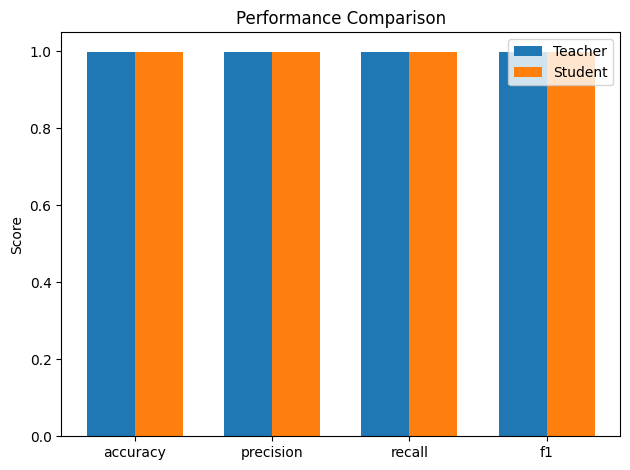

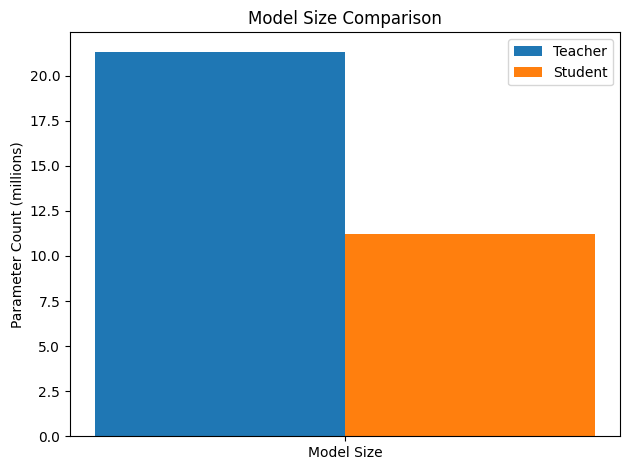

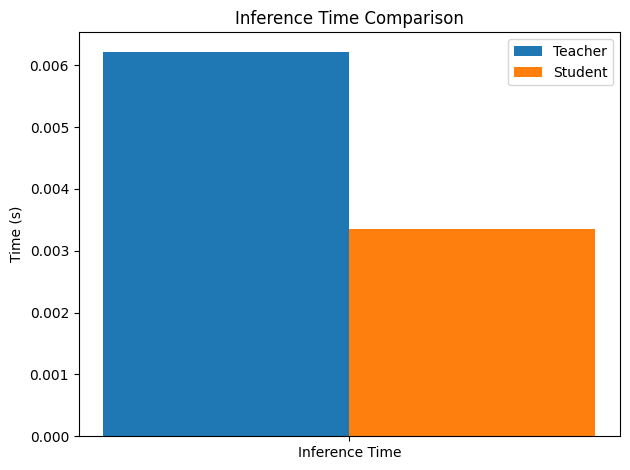

In [24]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.7169, 0.6135), 'precision': (0.7183939075629315, 0.6202347909860816), 'recall': (0.7169, 0.6135), 'f1': (0.7153472542156166, 0.6128989430589032)}


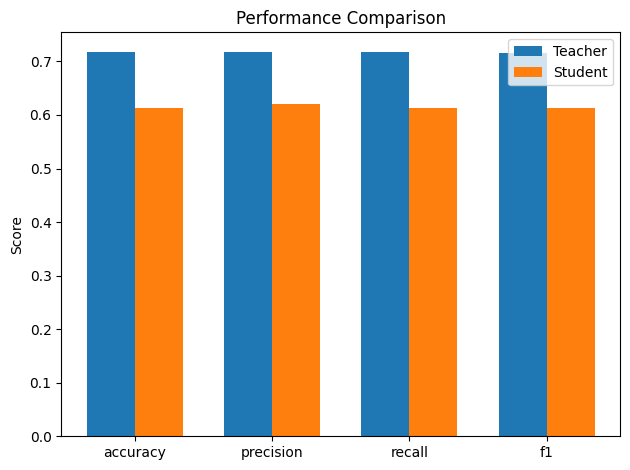

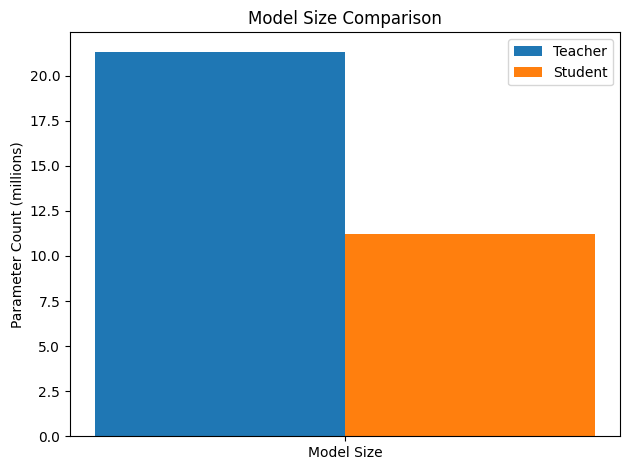

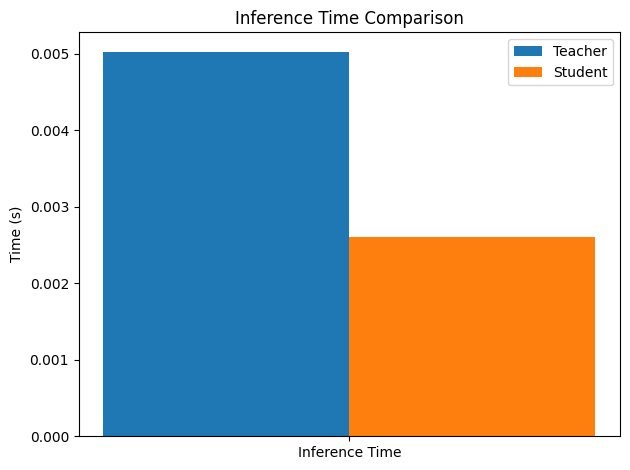

In [25]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')